In [6]:
from statsmodels.api import Logit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [132]:
sns.set_style("darkgrid")

In [3]:
%matplotlib inline

## <font color="#104E8B">数据集拆分

In [5]:
data = pd.read_csv(r"your file path")

In [10]:
train_X, test_X, train_y, test_y = train_test_split(data, data["flagy"], train_size=0.7, random_state=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## <font color="#104E8B">woe转换

* 在该部分，将入模变量，转换为woe，下面仅展示了两个变量的woe转换逻辑，其他以此类推，每个变量都定义一个转换函数

In [11]:
def transfor_rh_query_credit_num(x):
    if x <= -99: return -0.5799
    elif x <= 2: return -0.0746
    elif x <= 6: return 0.0219
    elif x <= 9: return 0.3036
    else: return 0.6213
    
def transfor_rh_credit_reject_num(x):
    if x <= 0: return -0.5014
    elif x <= 1: return -0.9585
    elif x <= 3: return 0.3494
    elif x <= 10: return 0.6273
    else: return 0.8468
    

* 对训练集进行woe转换。一下仅展示两个变量的转换过程，其他变量以此类推

In [13]:
train_X["woe_rh_query_credit_num"] = train_X["rh_query_credit_num"].apply(transfor_rh_query_credit_num)
train_X["woe_rh_credit_reject_num"] = train_X["rh_credit_reject_num"].apply(transfor_rh_credit_reject_num)

* 对测试集进行woe转换

In [ ]:
test_X["woe_rh_query_credit_num"] = test_X["rh_query_credit_num"].apply(transfor_rh_query_credit_num)
test_X["woe_rh_credit_reject_num"] = test_X["rh_credit_reject_num"].apply(transfor_rh_credit_reject_num)

## <font color="#104E8B"> 模型训练

* 经过woe转换后的入模变量

In [32]:
features = [
    "woe_rh_query_credit_num",
    "woe_rh_credit_reject_num",
    "woe_rh_loan_reject_num",
    "woe_rh_m12_max_rate_credit_Utilization",
    "woe_rh_sum_price_rate",
    "woe_rh_m12_credit_num"
]

* 开始训练

In [34]:
lr = Logit(train_y, train_X[features]).fit()

Optimization terminated successfully.
         Current function value: 0.606714
         Iterations 5


* 模型参数和统计指标

In [36]:
lr.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Logit
======================================================================================
Model:                     Logit                   Pseudo R-squared:        -3.642    
Dependent Variable:        flagy2                  AIC:                     12380.4648
Date:                      2019-11-26 17:07        BIC:                     12423.8416
No. Observations:          10193                   Log-Likelihood:          -6184.2   
Df Model:                  5                       LL-Null:                 -1332.2   
Df Residuals:              10187                   LLR p-value:             1.0000    
Converged:                 1.0000                  Scale:                   1.0000    
No. Iterations:            5.0000                                                     
--------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------
woe_rh_query_credit_num                -0.2284   0.0737 -3.0984 0.0019 -0.3728 -0.0839
woe_rh_credit_reject_num                0.8442   0.0462 18.2827 0.0000  0.7537  0.9348
woe_rh_loan_reject_num                  0.9055   0.0405 22.3821 0.0000  0.8262  0.9848
woe_rh_m12_max_rate_credit_Utilization  0.5712   0.0826  6.9170 0.0000  0.4093  0.7330
woe_rh_sum_price_rate                   0.9917   0.0934 10.6127 0.0000  0.8085  1.1748
woe_rh_m12_credit_num                   0.7638   0.1224  6.2407 0.0000  0.5239  1.0037
======================================================================================

"""

* 共线性（VIF）

In [305]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_score(X):
    var = X.columns
    X = X.values
    vifs = {var[i]: variance_inflation_factor(X, i)for i in range(X.shape[1])}
    return vifs

In [310]:
pd.Series(vif_score(train_X[features]))

woe_rh_query_credit_num                   2.006324
woe_rh_credit_reject_num                  1.535417
woe_rh_loan_reject_num                    1.225022
woe_rh_m12_max_rate_credit_Utilization    1.196093
woe_rh_sum_price_rate                     1.045625
woe_rh_m12_credit_num                     1.366520
dtype: float64

## <font color="#104E8B"> 模型效果

### <font color="#1C86EE"> 评分分布

In [285]:
def get_score(x):
    score=350-200*np.log2(x)
    score[score<300] = 300
    score[score>1000] = 1000
    return score

In [286]:
train_p = lr.predict(train_X[features])
train_score = get_score(train_p)

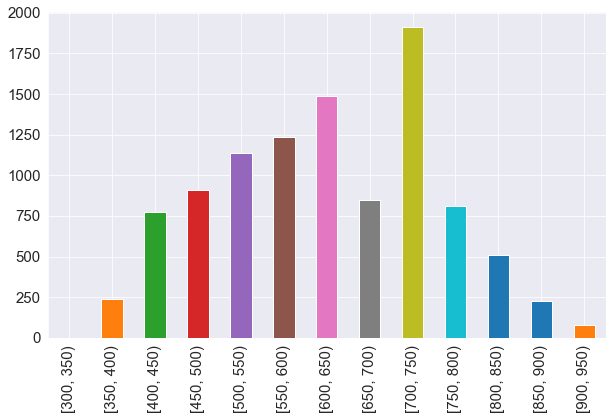

In [287]:
temp_train = pd.DataFrame({"proba":train_p,"score":train_score, "flagy":train_y})
temp_train["cut"] = pd.cut(temp_train["score"], bins=[i for i in range(300, 1000, 50)], right=False)
temp_train["cut"].value_counts().sort_index().plot.bar(figsize=(10, 6), fontsize=15)

### <font color="#1C86EE"> KS

In [288]:
ks = temp_train["flagy"].groupby(temp_train["cut"]).agg(["sum", "count"])
ks

,sum,count
cut,,
"[300, 350)",0.0,0
"[350, 400)",36.0,241
"[400, 450)",58.0,773
"[450, 500)",44.0,911
"[500, 550)",44.0,1138
"[550, 600)",40.0,1238
"[600, 650)",28.0,1487
"[650, 700)",9.0,849
"[700, 750)",22.0,1910


In [289]:
ks["count_cum"] = ks[["count"]].cumsum()
ks["bad_count_cum"] = ks[["sum"]].cumsum()
ks["good_count_cum"] = ks["count_cum"] - ks["bad_count_cum"]
ks["bad_rate_cum"] = ks["bad_count_cum"]/ks["bad_count_cum"].max()
ks["good_rate_cum"] = ks["good_count_cum"]/ks["good_count_cum"].max()
ks["ks_curve"] = np.abs(ks["bad_rate_cum"] - ks["good_rate_cum"])

In [290]:
ks

,sum,count,count_cum,bad_count_cum,good_count_cum,bad_rate_cum,good_rate_cum,ks_curve
cut,,,,,,,,
"[300, 350)",0.0,0,0,0.0,0.0,0.000000,0.000000,0.000000
"[350, 400)",36.0,241,241,36.0,205.0,0.122449,0.020745,0.101704
"[400, 450)",58.0,773,1014,94.0,920.0,0.319728,0.093099,0.226629
"[450, 500)",44.0,911,1925,138.0,1787.0,0.469388,0.180834,0.288554
"[500, 550)",44.0,1138,3063,182.0,2881.0,0.619048,0.291540,0.327507
"[550, 600)",40.0,1238,4301,222.0,4079.0,0.755102,0.412771,0.342331
"[600, 650)",28.0,1487,5788,250.0,5538.0,0.850340,0.560413,0.289927
"[650, 700)",9.0,849,6637,259.0,6378.0,0.880952,0.645416,0.235536
"[700, 750)",22.0,1910,8547,281.0,8266.0,0.955782,0.836470,0.119312


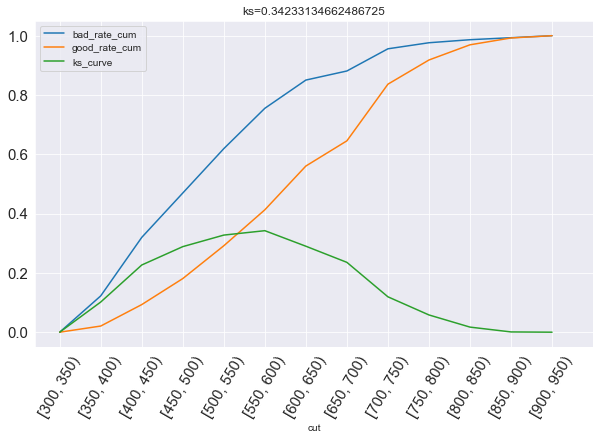

In [291]:
ks[["bad_rate_cum","good_rate_cum","ks_curve"]].plot(title="ks={}".format(ks["ks_curve"].max()),
                                                     xticks=range(14), rot=60, figsize=(10, 6), fontsize=15,)

### <font color="#1C86EE"> ROC

In [292]:
from sklearn.metrics import roc_curve, auc

In [293]:
fpr, tpr, thresholds = roc_curve(train_y, train_score, pos_label=0)
auc_score = auc(fpr, tpr)

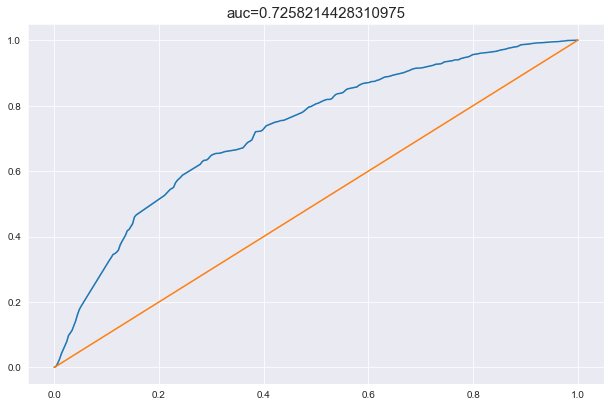

In [294]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes((0, 0, 1, 1))
ax.set_title(label='auc={}'.format(auc_score),size=15)
sns.lineplot(fpr, tpr, ax=ax)
sns.lineplot([0, 1], [0,1],ax=ax)

## <font color="#104E8B">模型稳定性验证

In [295]:
test_p = lr.predict(test_X[features])
test_score = get_score(test_p)

### <font color="#1C86EE"> 测试集评分分布

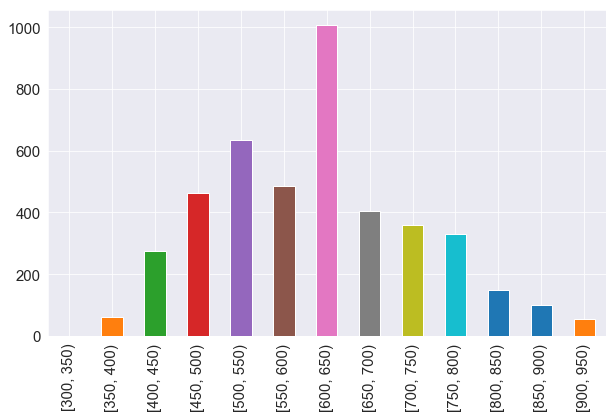

In [296]:
temp_test = pd.DataFrame({"proba":test_p,"score":test_score, "flagy":test_y})
temp_test["cut"] = pd.cut(temp_test["score"], bins=[i for i in range(300, 1000, 50)], right=False)
temp_test["cut"].value_counts().sort_index().plot.bar(figsize=(10, 6), fontsize=15)

### <font color="#1C86EE"> 测试集ks

In [297]:
ks_test = temp_test["flagy"].groupby(temp_test["cut"]).agg(["sum", "count"])
ks_test

,sum,count
cut,,
"[300, 350)",0.0,0
"[350, 400)",12.0,62
"[400, 450)",18.0,276
"[450, 500)",29.0,463
"[500, 550)",14.0,633
"[550, 600)",9.0,486
"[600, 650)",15.0,1006
"[650, 700)",4.0,404
"[700, 750)",6.0,359


In [298]:
ks_test["count_cum"] = ks_test[["count"]].cumsum()
ks_test["bad_count_cum"] = ks_test[["sum"]].cumsum()
ks_test["good_count_cum"] = ks_test["count_cum"] - ks_test["bad_count_cum"]
ks_test["bad_rate_cum"] = ks_test["bad_count_cum"]/ks_test["bad_count_cum"].max()
ks_test["good_rate_cum"] = ks_test["good_count_cum"]/ks_test["good_count_cum"].max()
ks_test["ks_curve"] = np.abs(ks_test["bad_rate_cum"] - ks_test["good_rate_cum"])

In [299]:
ks_test

,sum,count,count_cum,bad_count_cum,good_count_cum,bad_rate_cum,good_rate_cum,ks_curve
cut,,,,,,,,
"[300, 350)",0.0,0,0,0.0,0.0,0.000000,0.000000,0.000000
"[350, 400)",12.0,62,62,12.0,50.0,0.107143,0.011874,0.095269
"[400, 450)",18.0,276,338,30.0,308.0,0.267857,0.073142,0.194715
"[450, 500)",29.0,463,801,59.0,742.0,0.526786,0.176205,0.350581
"[500, 550)",14.0,633,1434,73.0,1361.0,0.651786,0.323201,0.328585
"[550, 600)",9.0,486,1920,82.0,1838.0,0.732143,0.436476,0.295667
"[600, 650)",15.0,1006,2926,97.0,2829.0,0.866071,0.671812,0.194260
"[650, 700)",4.0,404,3330,101.0,3229.0,0.901786,0.766801,0.134984
"[700, 750)",6.0,359,3689,107.0,3582.0,0.955357,0.850629,0.104728


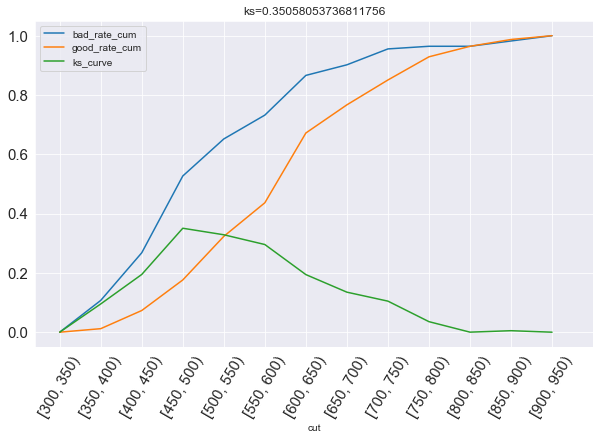

In [300]:
ks_test[["bad_rate_cum","good_rate_cum","ks_curve"]].plot(title="ks={}".format(ks_test["ks_curve"].max()),
                                                     xticks=range(14), rot=60, figsize=(10, 6), fontsize=15,)

### <font color="#1C86EE"> psi

In [301]:
psi = ks[["count"]].merge(ks_test[["count"]], left_index=True, right_index=True)
psi

,count_x,count_y
cut,,
"[300, 350)",0,0
"[350, 400)",241,62
"[400, 450)",773,276
"[450, 500)",911,463
"[500, 550)",1138,633
"[550, 600)",1238,486
"[600, 650)",1487,1006
"[650, 700)",849,404
"[700, 750)",1910,359


In [302]:
psi["train_dist"] = psi["count_x"]/psi["count_x"].sum()
psi["test_dist"] = psi["count_y"]/psi["count_y"].sum()

In [303]:
psi_score = sum((psi["train_dist"]-psi["test_dist"])*np.log((psi["train_dist"]+0.001)/(psi["test_dist"]+0.001)))

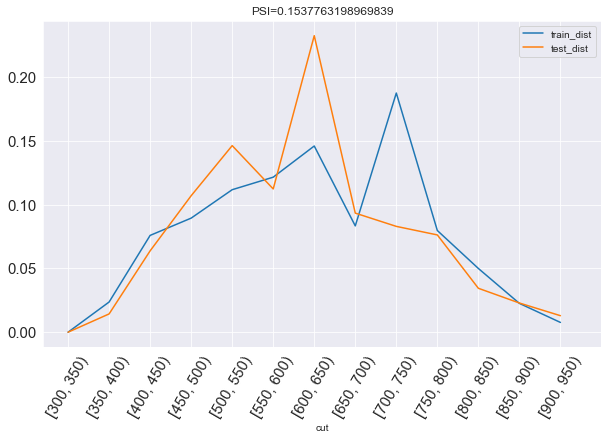

In [304]:
psi[["train_dist", "test_dist"]].plot(figsize=(10, 6), fontsize=15, title="PSI={}".format(psi_score), 
                                      xticks=range(14), rot=60)